In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

folder_path = "20230530_segm_black_mouse_mnSLA_red_and_black_back"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [133]:
def augmentation():
    count_image = 250
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    image_files = os.listdir(path_images)
    selected_files_for_vertical = random.sample(image_files, count_image)

    for filename in selected_files_for_vertical:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_images, f'revert_vertical_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    # selected_files_for_horizontal = []
    count_image = 1
    selected_files_for_horizontal = random.sample(image_files, count_image)

    for filename in selected_files_for_horizontal:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    return selected_files_for_vertical, selected_files_for_horizontal


def delete_generated_images(data_vert, data_hor):
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    for filename in data_vert:
        output_image_path = os.path.join(path_images, f'revert_vertical_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        os.remove(output_mask_path)

    for filename in data_hor:
        output_image_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        os.remove(output_mask_path)

In [134]:
def make_csv_files(folder_path, folder):
    images_folder = folder_path + "/" + folder + "images"
    masks_folder = folder_path + "/" + folder + "masks"

    images_files = os.listdir(images_folder)
    masks_files = os.listdir(masks_folder)

    image_paths = [os.path.join(folder + "images", file) for file in images_files]
    mask_paths = [os.path.join(folder + "masks", file) for file in masks_files]

    data = {'orig_image': image_paths, 'mask_image': mask_paths}
    df = pd.DataFrame(data)

    csv_file_path = "train_data.csv" if folder == "" else "test_data.csv"

    df.to_csv(csv_file_path, index=False)

In [136]:
data_vertical, data_horizontal = augmentation()
make_csv_files(folder_path, "")
make_csv_files(folder_path, "test_")

In [2]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [3]:
def draw(orig_image, orig_masks, mask_image, intersec_mask):
    fig, axes = plt.subplots(1, 4)

    orig_image = orig_image.transpose(1, 2, 0)
    orig_image = (np.array(orig_image) - np.min(orig_image)) / (np.max(orig_image) - np.min(orig_image))
    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')

    axes[1].imshow(orig_masks)
    axes[1].set_title('Original Mask')
    
    axes[2].imshow(mask_image)
    axes[2].set_title('Predicted Mask')

    axes[3].imshow(intersec_mask)
    axes[3].set_title('Difference Mask')

    plt.tight_layout()
    plt.show()

In [4]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [5]:
def compute_ap(predictions, targets):
    total_sum = 0.0
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    eps = 1e-7
    for prediction, target in zip(predictions, targets):
        for threshold in thresholds:
            output_thresh = (prediction>= threshold).astype(float)
            tp = np.sum(output_thresh * target)
            fp = np.sum(output_thresh * (1 - target))
            fn = np.sum((1 - output_thresh) * target)
            precisions.append((tp + eps) / (tp + fp + eps))
            recalls.append((tp + eps) / (tp + fn + eps))

        total_sum += np.trapz(precisions, recalls)
    return total_sum / len(predictions)

### Preprocessing (подготовка данных)

In [6]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('L')

        orig_image = self.transform_image(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)

        return orig_image.float(), mask_image.float()

In [7]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (320, 320)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 16

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [17]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion, scheduler=None):
  train_losses = []
  val_losses = []
  iou_test = []

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))
    
    if scheduler is not None:
      scheduler.step(loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    predictions, _, orig_masks, _ = prediction(model, test_loader)
    iou = calculate_iou(predictions, orig_masks)
    iou_test.append(iou)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, IOU: {iou:.4f}")
  return model, train_losses, val_losses, iou_test

### Prediction function

In [9]:
def prediction(model, loader):
    model.eval()
    predictions = []
    orig_images = []
    orig_masks = []
    intersection_masks = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            outputs[outputs < 0] = 0
            outputs[outputs > 0] = 1
            predictions.append(outputs.cpu().numpy())
            orig_images.append(x_batch.cpu().numpy())
            orig_masks.append(y_batch.cpu().numpy())
            intersection = np.abs(outputs.cpu().numpy() - y_batch.cpu().numpy())
            intersection_masks.append(intersection)
    predictions = np.concatenate(predictions, axis=0).squeeze()
    orig_images = np.concatenate(orig_images, axis=0).squeeze()
    orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
    intersection_masks = np.concatenate(intersection_masks, axis=0).squeeze()
    return predictions, orig_images, orig_masks, intersection_masks

In [10]:
def validation(model, loader, images_to_draw):
    predictions, orig_images, orig_masks, intersection_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    ap = compute_ap(predictions, orig_masks)

    print(f"IOU: {iou}")
    print(f"AP: {ap}")

    for i in range(images_to_draw):
        draw(orig_images[i], orig_masks[i], predictions[i], intersection_masks[i])


### Experiments

In [11]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

In [12]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        d1 = self.up_conv_trans_1(x5)
        pad1 = padder(x4,d1)
        cat1 = torch.cat([x4,pad1],dim=1)
        uc1 = self.up_conv_1(cat1)
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [13]:
model = UNET(in_chnls = 3, n_classes = 1).to(device)

In [46]:
import segmentation_models_pytorch as smp
model = smp.Unet('resnet50', classes=1)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [47]:
import segmentation_models_pytorch as smp

learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
# criterion = nn.BCEWithLogitsLoss()
# criterion = smp.losses.JaccardLoss(mode='binary')
criterion = smp.losses.DiceLoss(mode='binary')
scheduler = optim.ReduceLROnPlateau(optimizer, 'min')

In [48]:
num_epochs = 20
model, train_losses, val_losses, iou_test = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion, scheduler)

100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Epoch [1/20], Train loss: 50.8209, Val loss: 5.1998, IOU: 0.7724


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Epoch [2/20], Train loss: 25.8625, Val loss: 1.4478, IOU: 0.8350


100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Epoch [3/20], Train loss: 7.9298, Val loss: 0.7499, IOU: 0.8257


100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Epoch [4/20], Train loss: 5.3320, Val loss: 0.6940, IOU: 0.8500


100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


Epoch [5/20], Train loss: 4.4172, Val loss: 0.5431, IOU: 0.8274


100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Epoch [6/20], Train loss: 3.9683, Val loss: 0.5182, IOU: 0.8152


100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


Epoch [7/20], Train loss: 3.7294, Val loss: 0.5151, IOU: 0.8625


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Epoch [8/20], Train loss: 3.5454, Val loss: 0.4863, IOU: 0.8465


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


Epoch [9/20], Train loss: 3.4192, Val loss: 0.4916, IOU: 0.8424


100%|██████████| 4/4 [00:00<00:00,  7.75it/s]


Epoch [10/20], Train loss: 3.2634, Val loss: 0.4736, IOU: 0.8440


100%|██████████| 4/4 [00:00<00:00,  7.62it/s]


Epoch [11/20], Train loss: 3.1749, Val loss: 0.4737, IOU: 0.8511


100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


Epoch [12/20], Train loss: 3.0846, Val loss: 0.4705, IOU: 0.8441


100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Epoch [13/20], Train loss: 2.9832, Val loss: 0.4704, IOU: 0.8284


100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


Epoch [14/20], Train loss: 2.8533, Val loss: 0.4705, IOU: 0.8381


100%|██████████| 4/4 [00:00<00:00,  8.25it/s]


Epoch [15/20], Train loss: 2.7894, Val loss: 0.4670, IOU: 0.8385


100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


Epoch [16/20], Train loss: 2.7159, Val loss: 0.4677, IOU: 0.8472


100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Epoch [17/20], Train loss: 2.6460, Val loss: 0.4738, IOU: 0.8288


100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Epoch [18/20], Train loss: 2.6123, Val loss: 0.4665, IOU: 0.8324


100%|██████████| 4/4 [00:00<00:00,  7.87it/s]


Epoch [19/20], Train loss: 2.5514, Val loss: 0.4757, IOU: 0.8275


100%|██████████| 4/4 [00:00<00:00,  7.94it/s]


Epoch [20/20], Train loss: 2.5398, Val loss: 0.4668, IOU: 0.8381


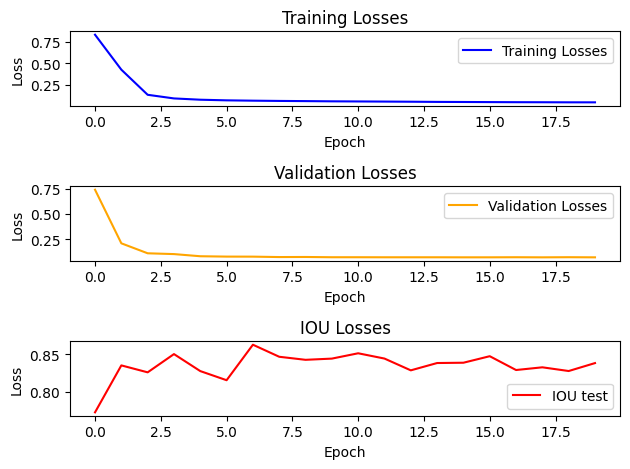

In [49]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(iou_test, label='IOU test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('IOU Losses')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

In [1]:
validation(model, train_loader, 1)

NameError: name 'validation' is not defined

100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


IOU: 0.838760738430247
AP: -0.031852769672403594


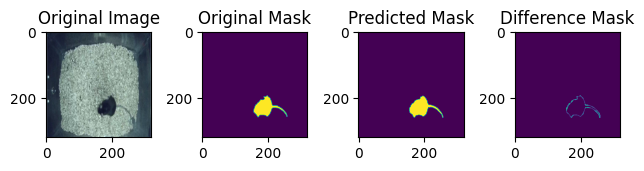

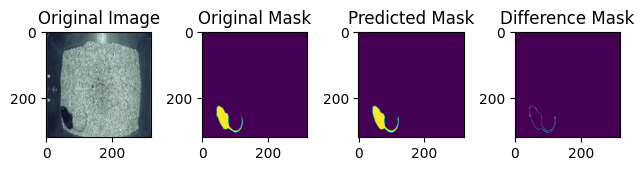

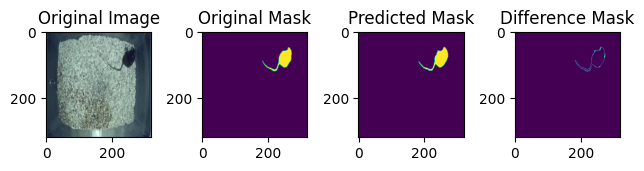

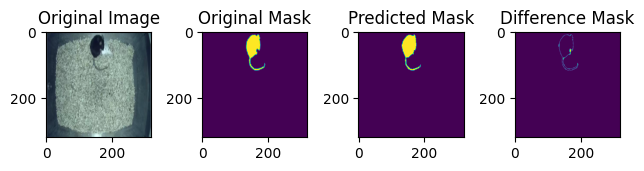

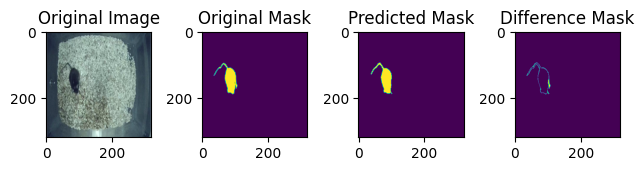

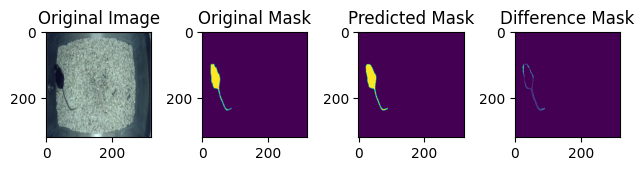

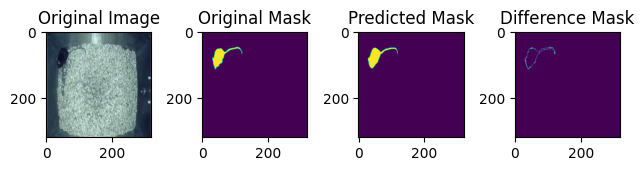

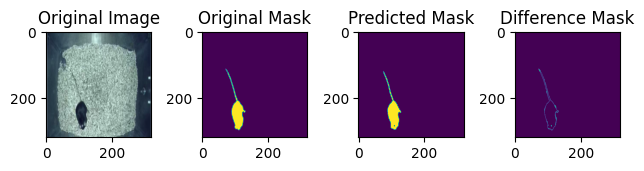

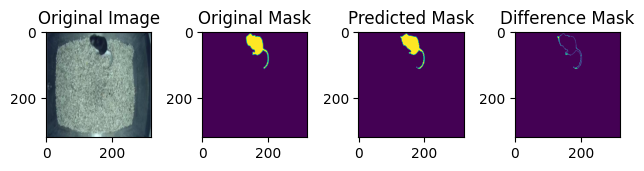

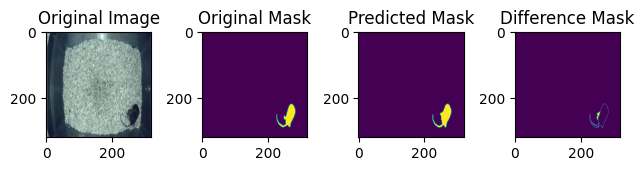

In [51]:
validation(model, val_loader, 10)

In [ ]:
validation(model, test_loader, 10)

validation(model, test_loader, 10)

In [158]:
delete_generated_images(data_vertical, data_horizontal)

FileNotFoundError: [WinError 2] Не удается найти указанный файл: '20230530_segm_black_mouse_mnSLA_red_and_black_back/images\\revert_vertical_ch12_20230523180211_20230523190211@000648.bmp'